In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai import *
from fastai.vision import *

from glob import glob
import seaborn as sns

%matplotlib inline

%cd /content/drive/My\ Drive/alfalfa-convnets

PATH = os.path.abspath('.')

/content/drive/My Drive/alfalfa-convnets


# Generate catalog with many galaxy properties

This is based off the "COLAB - Exploratory convnets" notebook.

In [0]:
# from the a.40 (x) DR7 catalog, only keep those with imaging and have OCcode = 'I'
df = pd.read_csv(f'{PATH}/data/a40.datafile3.csv')

df2 =  pd.read_csv(f'{PATH}/data/a40.datafile1.csv')
df2.rename(columns={'logMsun': 'logMHI'}, inplace=True)

ids = np.array([os.path.basename(fn).strip('.jpg') for fn in glob(f'{PATH}/images-OC/*.jpg')], dtype=int)

a40 = df.join(df2.set_index('AGCNr'), on='AGCNr', rsuffix='_sdss')
a40 = a40[(a40.AGCNr.isin(ids)) & (a40.OCcode == 'I') & (a40.logMHI.notna())].copy()

a40.rename(columns={'PhotoObjID': 'DR7ObjID'}, inplace=True)
a40 = a40[['AGCNr', 'DR7ObjID', 'logMHI']].copy()

In [0]:
# load sdss DR14 catalog (containing DR7 objIDs) with stellar mass, SFR, etc.
sdss =  pd.read_csv(f'{PATH}/data/SDSS_basic_data.csv')

sdss.rename(columns={'lgm_tot_p50': 'logMstar', 'oh_p50': 'Zgas', 'sfr_tot_p50': 'logSFR'}, inplace=True)
sdss.drop_duplicates(subset='DR7ObjID', keep=False, inplace=True)
sdss = sdss[(sdss.logMstar > 0) & (sdss.Zgas > 0) & (sdss.logSFR > -10)].copy()
sdss = sdss[['DR7ObjID', 'logMstar', 'logSFR', 'Zgas']].copy()



In [0]:
# make joined catalog, create column for gas mass fraction 
joined = a40.join(sdss.set_index('DR7ObjID'), on='DR7ObjID', how='left', rsuffix='_sdss')
joined = joined[joined.logMstar.notna() & joined.logSFR.notna() & joined.Zgas].copy()

joined['logfgas'] = joined.logMHI - joined.logMstar

In [0]:
joined.sample(5)

,AGCNr,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas
937,174519,587741421632291207,10.19,9.463515,-0.045169,8.845638,0.726485
10108,241716,587736545773682791,9.67,9.808047,-0.082048,9.070118,-0.138047
4224,202237,587732703941493174,9.53,8.805254,-0.854967,8.454058,0.724746
3773,202417,587734948058169462,9.94,9.002408,-0.612896,8.535501,0.937592
6418,724734,587741722283212869,9.90,9.707209,0.519542,8.859581,0.192791


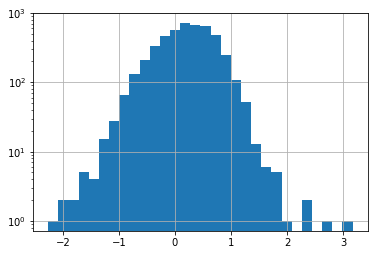

In [0]:
joined.logfgas.hist(bins=30)
plt.yscale('log')

In [0]:
!pip install corner

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11644 sha256=b5788f94e5d873bbf15338e786103baf811d1ae238a259d822b600ea82a0d349
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


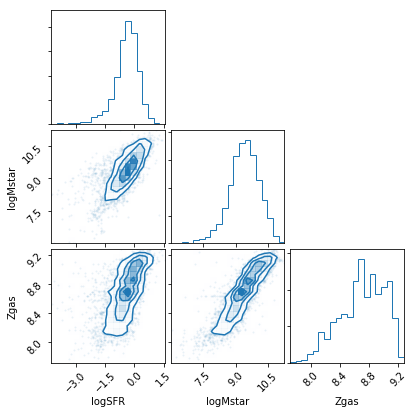

In [0]:
import corner

fig, axes = plt.subplots(3, 3, figsize=(6, 6))

corner.corner(subdf, color='C0', fig=fig);

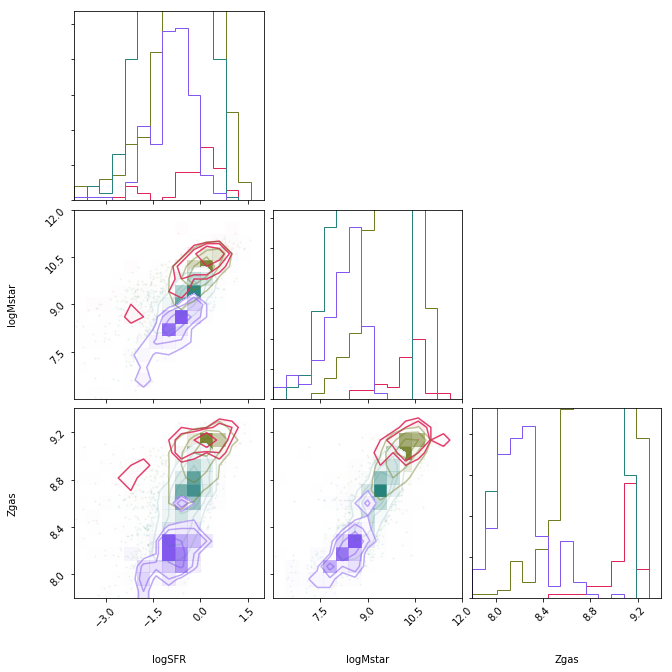

In [0]:
subdf = joined[['logSFR', 'logMstar', 'Zgas']].copy()

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# plotting: 
# red:    -2 < logfgas < -1
# yellow: -1 < logfgas <  0
# teal:    0 < logfgas <  1
# violet:  1 < logfgas <  2
n_bins = 4
cmap = sns.husl_palette(n_colors=4, l=0.5)

for i, c in enumerate(cmap):
    
    logfgas_range = (joined.logfgas >= i-2) & (joined.logfgas < i-1)
    
    corner.corner(subdf[logfgas_range], bins=15, range=[(-4, 2), (6., 12), (7.8, 9.4)], color=c, fig=fig);


In [0]:
# add sSFR column then save catalog
joined['logsSFR'] = joined.logSFR - joined.logMstar
joined.to_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

# Jointly train convnet to learn all galaxy properties

In [0]:
bs = 128
sz = 224


In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

# get Zgas closer to a median of 0
df.Zgas -= 8.8


src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2)
                .label_from_df(cols=['logfgas', 'logsSFR', 'logMstar', 'Zgas'],  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize())

In [0]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, loss_func=root_mean_squared_error)

In [0]:
learn.fit(1, 0.03)

epoch,train_loss,valid_loss,time
0,2.073065,1.134484,00:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


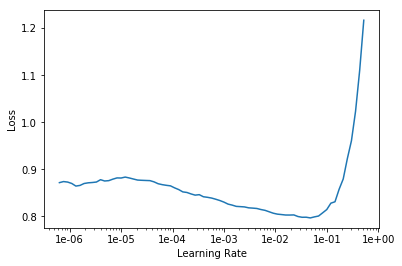

In [0]:
# unfreeze model!
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(40, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,time
0,0.785671,0.487901,00:35
1,0.748659,0.457658,00:34
2,0.722751,0.410827,00:35
3,0.700536,0.440846,00:34
4,0.678772,0.407698,00:34
5,0.654643,0.448199,00:35
6,0.631131,0.395924,00:34
7,0.609149,0.430897,00:34
8,0.580691,0.356614,00:34
9,0.557357,0.407020,00:35


(0.2, 0.6)

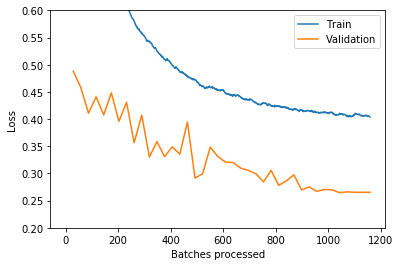

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.6)

In [0]:
learn.save('a.40_all-galaxy-properties_resnet34-40ep')

In [0]:
pred, true = learn.TTA()

In [0]:
df[['logfgas', 'logsSFR', 'logMstar', 'Zgas']].head()

,logfgas,logsSFR,logMstar,Zgas
0,-0.447361,-9.905787,9.737361,0.186673
1,-0.350810,-9.809913,10.210810,0.290569
2,0.104468,-9.681126,9.565532,0.014389
3,-0.153950,-10.566188,10.153950,-0.028327
4,0.787134,-9.059992,7.962866,-0.625308


In [0]:
pred[:5]

tensor([[  0.2544,  -9.7380,   9.3557,  -0.0617],
        [ -0.0195,  -9.8376,   9.6680,   0.0913],
        [  0.2848, -10.1598,   9.2515,  -0.1428],
        [  0.7543,  -9.4582,   8.9387,  -0.3427],
        [  0.5308,  -9.5209,   9.2576,  -0.1681]])

In [0]:
# store results, along with AGC identifier, in new DataFrame
results = pd.DataFrame({'fgas_true': true[:,0].squeeze(), 'fgas_pred': pred[:,0].squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

In [0]:
# how well we've done in 
#   logfgas, logsSFR, logMstar, and Zgas
(true - pred).pow(2).mean(0).pow(0.5)

tensor([0.3149, 0.3926, 0.4033, 0.1824])

In [0]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def offset_image(objID, zoom=0.1):
    return OffsetImage(image2np(open_image(f'{PATH}/images-OC/{objID}.jpg').data), zoom=zoom)

def plot_results(results, show_images=True, zoom=0.4):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.scatter('fgas_true', 'fgas_pred', data=results, c='black')

    if show_images:
        artists = []
        for objID, [Z_true, Z_pred] in results.sample(100).iterrows():
            ab = AnnotationBbox(offset_image(objID, zoom=zoom), (Z_true, Z_pred), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
            
    # plot 1:1 line
    plt.plot([-4, 4], [-4, 4], c='C3', ls='--', lw='10')

    ax.set_xlim(-2, 1.5)
    ax.set_ylim(-2, 1.5)
    ax.set_xlabel(r'True log $\mu_{\rm gas}$')
    ax.set_ylabel(r'Pred log $\mu_{\rm gas}$')



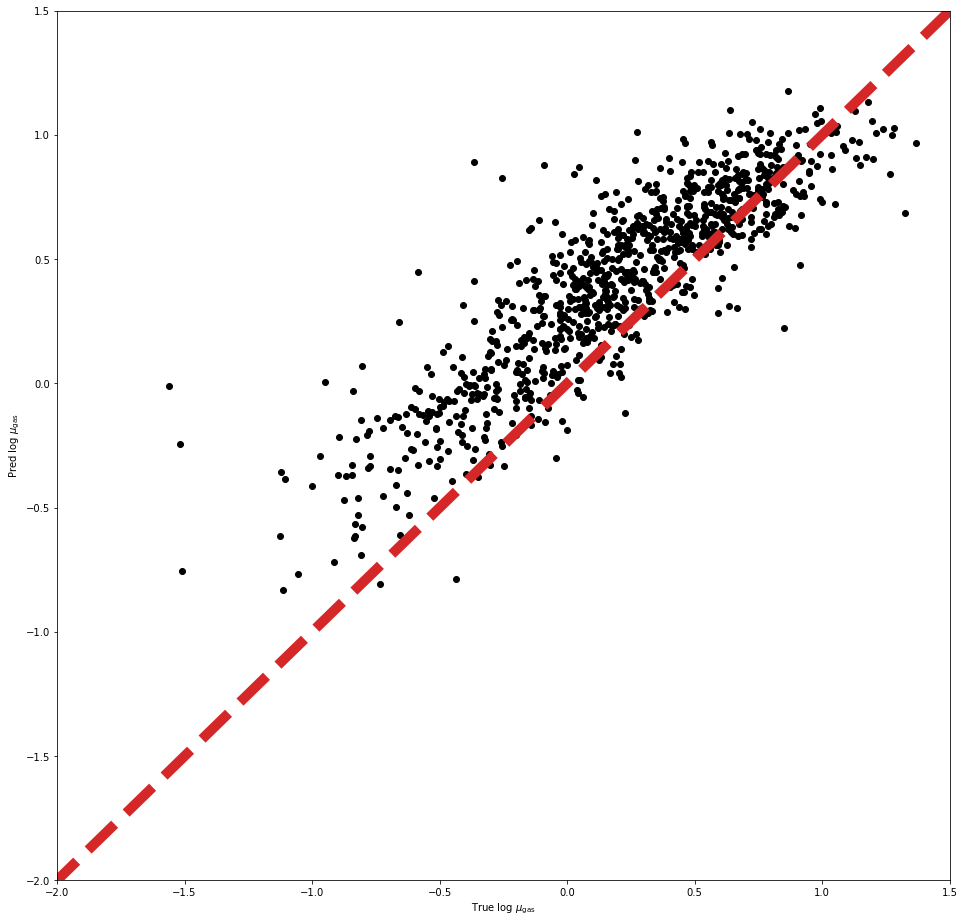

In [0]:
plot_results(results, show_images=False)

(-1, 1)

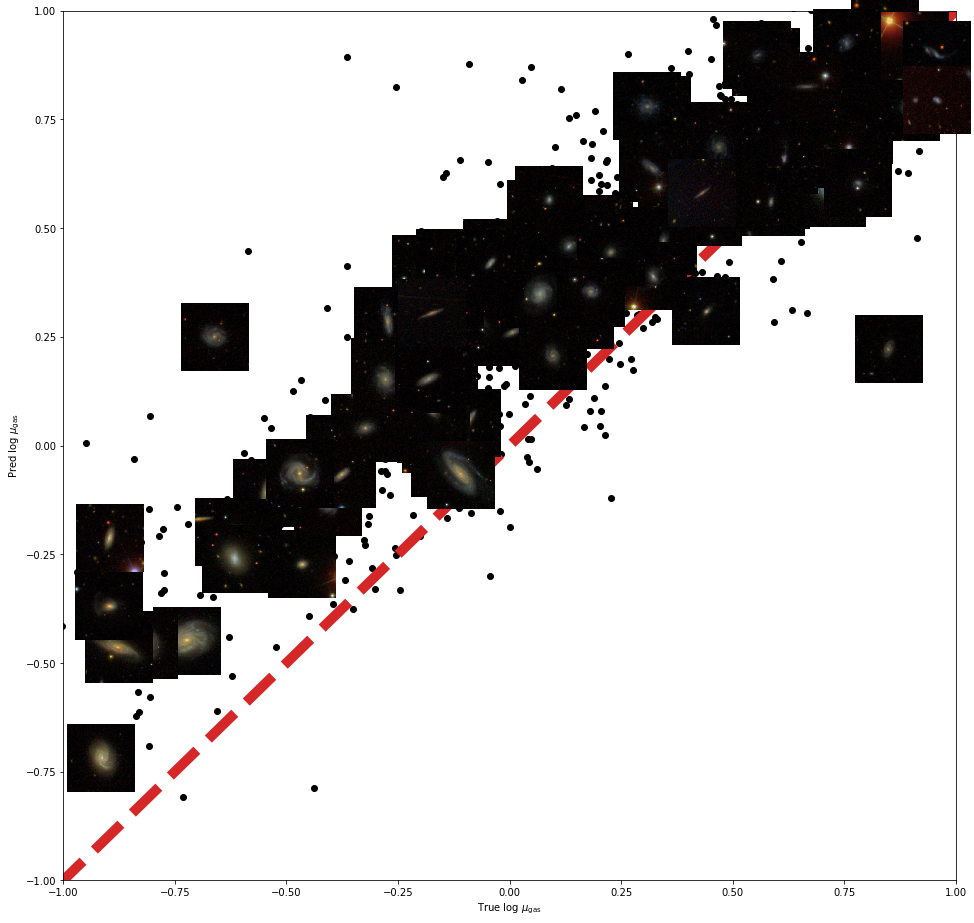

In [0]:
plot_results(results, show_images=True, zoom=0.3)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Continue training

In [0]:
all_properties_model = learn.model

In [0]:
learn.

In [0]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

# Reformulate as a classification problem?